In [1]:
import glob
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np

In [3]:
images = glob.glob('Checker_imgs/*.png') #Folder to pull images from

# Load calibration data
savedir = 'Calibration_imgData/'
mtx = np.load(savedir + 'Cam_Mtx.npy')
dist = np.load(savedir + 'Dist.npy')
rvecs = np.load(savedir + 'Rot.npy')
tvecs = np.load(savedir + 'Trans.npy')
roi = np.load(savedir + 'roi.npy')
optimalmtx = np.load(savedir + 'newCam_mtx.npy')


che = (11,8) # Checker-board INNER corners
Sq = 23 

In [14]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0][0])  # Extracting the first corner point
    corner = (int(corner[0]), int(corner[1]))  # Convert corner coordinates to integers
    imgpt0 = tuple(imgpts[0].ravel().astype(int))  # Convert imgpts coordinates to integers
    imgpt1 = tuple(imgpts[1].ravel().astype(int))
    imgpt2 = tuple(imgpts[2].ravel().astype(int))
    
    img = cv.line(img, corner, imgpt0, (255, 0, 0), 5)
    img = cv.line(img, corner, imgpt1, (0, 255, 0), 5)
    img = cv.line(img, corner, imgpt2, (0, 0, 255), 5)
    
    # Add lines for additional axes points if necessary
    for i in range(3, imgpts.shape[0]):
        imgpt = tuple(imgpts[i].ravel().astype(int))
        img = cv.line(img, corner, imgpt, (255, 255, 255), 3)  # Change color if necessary
        
    return img


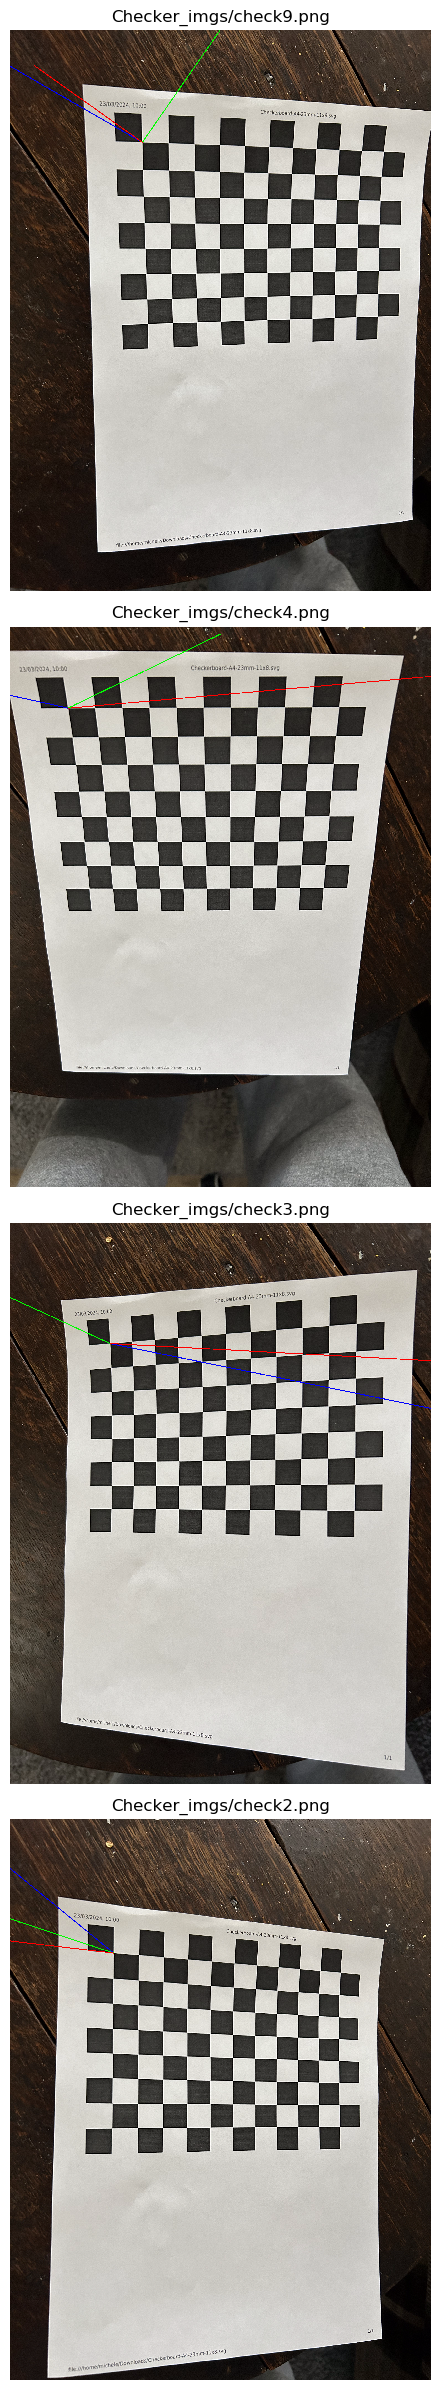

(0.0, 1.0, 0.0, 1.0)

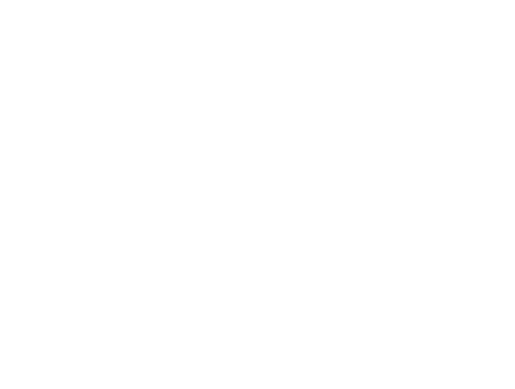

In [17]:

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((11*8, 3), np.float32)
objp[:, :2] = np.mgrid[0:11, 0:8].T.reshape(-1, 2)
 

fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(6, 6*len(images)))



for i, image in enumerate(images):
    img = cv.imread(image)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (11, 8), None) 
 
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
 
 # Find the rotation and translation vectors.
        ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
 
 # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
 
        img = draw(img,corners2,imgpts)
        
    #     cv.imwrite(image[:6]+'.png', img)
 
    # axes[i].imshow(gray, cmap='gray')
    # axes[i].set_title(image)  
        coordinates = '_'.join([f'{int(coord)}' for coord in corners2[0][0]])  # Example: "100_200"
        cv.imwrite(f"{image[:6]}_{coordinates}.png", img)
 
    axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
    axes[i].set_title(image)  
    axes[i].axis('off')  # Turn off axes

plt.tight_layout()
# Show the plot
plt.show()
plt.axis('off')





In [26]:

# Step 1: Feature Detection and Matching
img1 = cv.imread('michele1.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('michele2.jpg', cv.IMREAD_GRAYSCALE)


sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Step 2: Compute Fundamental Matrix
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
fundamental_matrix, _ = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)


# Step 3: Rectification
rectification_matrices = cv.stereoRectifyUncalibrated(pts1, pts2, fundamental_matrix, img1.shape[::-1])

if rectification_matrices is not None:
    rectification_matrix1 = rectification_matrices[0].astype(np.float32)
    rectification_matrix2 = rectification_matrices[1].astype(np.float32)

    # Step 4: Compute Disparity Map
    img1_rectified = cv.remap(img1, rectification_matrix1, None, cv.INTER_LINEAR)
    img2_rectified = cv.remap(img2, rectification_matrix2, None, cv.INTER_LINEAR)
else:
    print("Stereo rectification failed. Unable to compute disparity map.")


stereo = cv.StereoSGBM_create(minDisparity=0, numDisparities=64, blockSize=5)
disparity_map = stereo.compute(img1_rectified, img2_rectified)

# Step 5: Reconstruct 3D Point Cloud
depth_map = cv.reprojectImageTo3D(disparity_map)





# mathlab plot 
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(disparity_map / 16.0))
plt.axis('off') 
plt.title('ORiginal Image')
plt.subplot(1, 2, 2)
plt.imshow(depth_map)
plt.title('clustered image')
plt.axis('off') 
plt.show()


AttributeError: 'bool' object has no attribute 'astype'